In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

In [2]:
df = pd.read_csv("full_fundamental_dataset.csv")

/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_57169/3045277942.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("full_fundamental_dataset.csv")


Connecting to WRDS

In [2]:
conn=wrds.Connection()

Loading library list...
Done


Pull Compustat data

In [3]:
comp = conn.raw_sql("""
                    SELECT
                        f.gvkey,
                        f.fyear,
                        f.datadate,
                        c.sic,
                        f.exchg,
                        -- Required Fundamental Variables 
                        f.at,                             -- Total Assets
                        f.sale,                           -- Sales Revenue
                        f.ib,                             -- Income Before Extraordinary Items
                        f.csho,                           -- Common Shares Outstanding
                        -- Balance Sheet Items
                        f.act,                            -- Current Assets
                        f.che,                            -- Cash and Short-Term Investments
                        f.rect,                           -- Receivables
                        f.ppent,                          -- Property, Plant, and Equipment (Net)
                        f.ivao,                           -- Investments and Advances (Other)
                        f.invt,                           -- Inventories
                        f.ivst,                           -- Short-Term Investments
                        f.intan,                          -- Intangible Assets
                        f.ap,                             -- Accounts Payable
                        f.dlc,                            -- Debt in Current Liabilities
                        f.txp,                            -- Income Taxes Payable
                        f.lct,                            -- Total Current Liabilities
                        f.dltt,                           -- Long-Term Debt
                        f.lt,                             -- Total Liabilities
                        f.ceq,                            -- Common Equity
                        -- Income Statement Items
                        f.cogs,                           -- Cost of Goods Sold
                        f.xsga,                           -- Selling, General, and Administrative Expenses
                        f.xad,                            -- Advertising Expense
                        f.xrd,                            -- Research and Development Expense
                        f.xido,                           -- Extraordinary items and discontinued operations
                        f.xidoc,                          -- Extraordinary items and discontinued operations (Cumulative) 
                        f.dp,                             -- Depreciation and Amortization
                        f.xint,                           -- Interest and Related Expense
                        f.nopio,                          -- Non-operating income (expense) - other
                        f.txt,                            -- Income Taxes
                        f.spi,                            -- Special Items
                        f.dvc,                            -- Dividend payment
                        f.dvpsx_f,                        -- Common dividends per share
                        -- Cash Flow Statement Items
                        f.oancf,                          -- Operating Cash Flow
                        -- Fama-French Variables
                        f.seq,                            -- Shareholders' Equity
                        f.pstkl,                          -- Preferred Stock Liquidating Value
                        f.txditc,                         -- Deferred Taxes and Investment Tax Credit
                        f.pstkrv,                         -- Preferred Stock Redemption Value
                        f.pstk                            -- Preferred Stock
                    FROM
                        comp.funda f
                    JOIN
                        comp.company c ON f.gvkey = c.gvkey
                    WHERE
                        f.indfmt = 'INDL'                 -- Industrial Format
                        AND f.datafmt = 'STD'             -- Standard Format
                        AND f.popsrc = 'D'                -- Domestic data
                        AND f.consol = 'C'                -- Consolidated
                        AND f.datadate >= '1959-01-01'
                    """, date_cols=['datadate'])

Fetches annual fundamental financial data for companies. The query selects various financial statement items from the comp.funda table (annual data table) and joins it with the comp.company table to get the company's SIC code. Data is filtered to include only industrial firms with standard data format, domestic data source, and consolidated statements, and the time period is restricted to after 1959-01-01.

Book Equity Calculation

In [4]:
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

A new 'ps' column is created, representing preferred stock. It's calculated using a prioritized logic: 'pstkrv' > 'pstkl' > 'pstk' > 0. Missing values are handled in this order. The 'txditc' column is modified to have 0 instead of missing values. A new 'be' column is created, representing book equity. It's calculated as 'seq' + 'txditc' - 'ps'. Negative or zero values in 'be' are replaced with NaN.

Pull CRSP Data

In [5]:
crsp_m = conn.raw_sql("""
                      -- Select relevant stock market data from CRSP monthly stock file 
                     SELECT
                            a.permno,
                            a.permco,
                            a.date,
                            b.shrcd,
                            b.exchcd,
                            a.ret,
                            a.retx,
                            a.shrout,
                            a.prc
                     FROM crsp.msf AS a
                     LEFT JOIN crsp.msenames AS b
                     ON a.permno = b.permno
                     AND b.namedt <= a.date
                     AND a.date <= b.nameendt
                     WHERE a.date BETWEEN '01/01/1959' AND '12/31/2024'
                     AND b.exchcd BETWEEN 1 AND 3
                     AND b.shrcd in (10, 11)
                      """, date_cols=['date'])

crsp_m[['permco','permno','shrcd','exchcd', 'shrout']]=crsp_m[['permco','permno','shrcd','exchcd', 'shrout']].astype(int)

crsp_m['jdate']=crsp_m['date'] + MonthEnd(0)

1.	Data Extraction: \
•	Retrieves relevant monthly stock data from CRSP’s msf and msenames tables. \
•	Joins these tables on permno with appropriate date constraints to ensure accurate matching. 
2.	Data Filtering: \
•	Limits the dataset to records between January 1959 and December 2024. \
•	Focuses on major exchanges (exchcd 1-3) and specific share classes (shrcd 10, 11). 
3.	Data Cleaning and Preparation: \
•	Converts key identifier and classification columns to integer types for data integrity. \
•	Creates an adjusted date column (jdate) standardized to month-end dates to facilitate further analysis.

Add Delisting Return

In [6]:
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])

dlret.permno=dlret.permno.astype(int)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

1.	Data Extraction: \
•	Delisting Returns: Extracts delisting return information (dlret) along with associated security identifiers (permno) and delisting dates (dlstdt) from the CRSP msedelist table.
2.	Data Preparation: \
•	Type Conversion: Ensures permno is an integer and dlstdt is in datetime format. \
•	Date Standardization: Adjusts delisting dates to the end of their respective months (jdate) to align with monthly stock data.
3.	Data Integration: \
•	Merging Datasets: Combines the delisting returns data with the existing monthly stock dataset (crsp_m) based on permno and jdate, resulting in a comprehensive DataFrame (crsp) that includes both stock performance metrics and delisting information.
4.	Data Cleaning: \
•	Handling Missing Data: Fills in missing delisting returns (dlret) and raw returns (ret) with 0 to maintain data integrity and ensure that analyses are not skewed by incomplete data.

Notable Assumptions:
- Assumes that a missing 'dlret' value implies a delisting return of 0.
- Assumes that a missing 'ret' value can be treated as 0 (need to discuss best practice here)

retadj factors in the delisting returns

In [7]:
crsp['retadj']=(1 + crsp['ret']) * (1 + crsp['dlret']) - 1

Ensures that all sources of return, including those arising from delisting events, are accounted for. 

Calculate market equity

In [8]:
crsp['me']=crsp['prc'].abs() * crsp['shrout'] 
crsp = crsp.sort_values(by=['jdate','permco','me'])
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
crsp_maxme  = crsp.groupby(['jdate','permco'])['me'].max().reset_index()
crsp1 = pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])
crsp1 = crsp1.drop(['me'], axis=1) 
crsp2 = pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])
crsp2 = crsp2.sort_values(by=['permno','jdate']).drop_duplicates()

1.	Calculate Market Capitalization (me): \
•	Computes the market value of each security.
2.	Sort the Data: \
•	Organizes the data by date, company, and market equity to prepare for aggregation and filtering.
3.	Aggregate Total Market Equity (crsp_summe): \
•	Summarizes the total market value for each company on each date, accounting for all its securities.
4.	Identify the Largest Security (crsp_maxme): \
•	Determines the primary security representing each company based on market capitalization.
5.	Filter to Largest Securities (crsp1): \
•	Retains only the most significant security per company per date, ensuring a one-to-one relationship.
6.	Merge Aggregated Data and Finalize (crsp2): \
•	Integrates total market equity with the filtered securities and ensures data consistency through sorting and deduplication.

Notable Assumption: 
- Goal is to select one share per company per date for further analysis. Here, we select the observation with the largest market equity as the representative share for a company.

### Linking Compustat and CRSP

In [9]:
ccm = conn.raw_sql("""
                     SELECT
                            gvkey,
                            lpermno AS permno,
                            linktype,
                            linkprim,
                            linkdt,
                            linkenddt
                     FROM crsp.ccmxpf_linktable
                     WHERE
                            substr(linktype,1,1) = 'L'
                            AND (linkprim = 'C' OR linkprim = 'P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp,ccm,how='left',on=['gvkey'])
ccm1['fye'] = ccm1['datadate']
ccm1['yearend']=ccm1['datadate'] + YearEnd(0)
ccm1['jdate']=ccm1['yearend'] + MonthEnd(3)

1.	Extract Linkage Information: \
•	Query the CCM link table to obtain mappings between Compustat’s gvkey and CRSP’s permno, focusing on primary linkages valid within specified date ranges.
2.	Handle Missing Link End Dates: \
•	Assign the current date to any missing linkenddt values, ensuring all linkages have defined validity periods.
3.	Merge Compustat Data with Linkage Information: \
•	Perform a left join to associate each Compustat company (gvkey) with its corresponding CRSP security (permno), retaining all Compustat records.
4.	Create Standardized Fiscal and Join Dates: \
•	Assign datadate as the fiscal year-end (fye). \
•	Adjust datadate to the fiscal year-end (yearend) using YearEnd(0). \
•	Compute jdate by advancing yearend by three months to align with CRSP’s quarterly data using MonthEnd(3).

Notable Assumption:
- Assumes that a 3-month lag is appropriate for the availability of Compustat data after the fiscal year-end.

In [10]:
ccm2 = ccm1[
    (ccm1['jdate'] >= ccm1['linkdt']) &
    (ccm1['jdate'] <= ccm1['linkenddt'])
]

ccm2 = ccm2.sort_values('jdate')
crsp2 = crsp2.sort_values('jdate')

# Merge
ccm2['permno'] = ccm2['permno'].astype('Int64')
crsp2['permno'] = crsp2['permno'].astype('Int64')
ccm_merged = pd.merge_asof(
    ccm2,             
    crsp2,           
    on='jdate',       
    by='permno',      
    direction='backward'  
)

ccm_merged['beme'] = ccm_merged['be'] * 1000 / ccm_merged['me']

1. Filter Data Based on Date Range:
- Create a new DataFrame ccm2 by selecting rows from ccm1 where:
- The jdate is greater than or equal to the linkdt, and the jdate is less than or equal to the linkenddt.

2. Sort DataFrames by Date: Sort ccm2 by the jdate column, sort crsp2 by the jdate column.

3. Prepare Columns for Merging:
- Convert the permno column in both ccm2 and crsp2 to the integer type (Int64) to ensure data type consistency.

4. Merge the DataFrames:
- Perform an “as-of” merge using pd.merge_asof:
- Left DataFrame: ccm2
- Right DataFrame: crsp2
- Merge Key: jdate (the merge will align rows based on this date)
- Grouping Column: permno (ensures that the merge only considers rows with the same identifier)
- Merge Direction: backward (for each row in ccm2, merge with the most recent preceding row in crsp2 based on jdate)

5. Compute a New Variable:
- In the merged DataFrame ccm_merged, calculate a new column beme as:
- $\text{beme} = \frac{\text{be} \times 1000}{\text{me}}$

### Filtering

In [11]:
start_date = '1965-01-01'
end_date   = '2024-12-31'
filtered_data = ccm_merged[
    (ccm_merged['jdate'] >= start_date) &
    (ccm_merged['jdate'] <= end_date)
]
filtered_data['year'] = filtered_data['jdate'].dt.year
# (a) Non-missing key items: at, sale, ib, csho
filtered_data_a = filtered_data.dropna(subset=['at', 'sale', 'ib', 'csho'])

# (b) Exclude financials (6000–6999) and utilities (4900–4999)
filtered_data_a['sic'] = filtered_data_a['sic'].astype(str).str.zfill(4)
filtered_data_b = filtered_data_a[~(
    ((filtered_data_a['sic'] >= '6000') & (filtered_data_a['sic'] <= '6999')) |
    ((filtered_data_a['sic'] >= '4900') & (filtered_data_a['sic'] <= '4999'))
)]

# (c) Stock price > $1 at end of 3rd month after actual FYE
filtered_data_b['yearend'] = filtered_data_b['datadate'] + YearEnd(0)
filtered_data_b['target_price_date'] = filtered_data_b['yearend'] + pd.DateOffset(months=3) + MonthEnd(0)

# Merge CRSP price data, looking for the price *on or before* the target date.
price_check_crsp = crsp_m[['permno', 'date', 'prc', 'shrout']].rename(
    columns={'date': 'price_check_date_crsp', 'prc': 'price_at_check_date', 'shrout': 'shrout_at_check_date'}
).sort_values('price_check_date_crsp')

price_check_crsp['permno'] = price_check_crsp['permno'].astype('Int64')

filtered_data_c = pd.merge_asof(filtered_data_b.sort_values('target_price_date'),
                                price_check_crsp,
                                left_on='target_price_date',
                                right_on='price_check_date_crsp',
                                by='permno',
                                direction='backward') 

# Filter out rows where the price is missing or less than $1
filtered_data_c = filtered_data_c[filtered_data_c['price_at_check_date'].abs() > 1]

# Imputation step
items_to_zero = ['spi', 'ap', 'txp', 'xint', 'ivao', 'xsga', 'intan', 'ivst', 'xrd', 'xad', 'lct', 'act', 'dvpsx_f']
for item in items_to_zero:
    filtered_data_c[item] = filtered_data_c[item].fillna(0)

filtered_data_c['che_lag'] = filtered_data_c.groupby('gvkey')['che'].shift(1)
filtered_data_c['dlc_lag'] = filtered_data_c.groupby('gvkey')['dlc'].shift(1)
filtered_data_c['act_lag'] = filtered_data_c.groupby('gvkey')['act'].shift(1)
filtered_data_c['lct_lag'] = filtered_data_c.groupby('gvkey')['lct'].shift(1)
filtered_data_c['txp_lag'] = filtered_data_c.groupby('gvkey')['txp'].shift(1)
filtered_data_c['accruals'] = (
    (filtered_data_c['act'] - filtered_data_c['act_lag'])
    - (filtered_data_c['che'] - filtered_data_c['che_lag'])
    - (
        (filtered_data_c['lct'] - filtered_data_c['lct_lag'])
        - (filtered_data_c['dlc'] - filtered_data_c['dlc_lag'])
        - (filtered_data_c['txp'] - filtered_data_c['txp_lag']) 
    )
    - filtered_data_c['dp']
)
filtered_data_c['CFO_calc'] = filtered_data_c['ib'] - filtered_data_c['accruals'] 
filtered_data_c['oancf'] = filtered_data_c['oancf'].fillna(filtered_data_c['CFO_calc'])
filtered_data_c['oancf'] = filtered_data_c['oancf'] - filtered_data_c['xido'].fillna(0)
filtered_data_c['E'] = filtered_data_c['ib'] - filtered_data_c['spi']

variables = {
    'SALE': 'sale',
    'COGS': 'cogs',
    'XSGA': 'xsga',
    'XAD': 'xad',
    'XRD': 'xrd',
    'DP': 'dp',
    'XINT': 'xint',
    'NOPIO': 'nopio',
    'TXT': 'txt',
    'XIDO': 'xido',
    'E': 'E',  
    'DVC': 'dvc',
    'CHE': 'che',
    'INVT': 'invt',
    'RECT': 'rect',
    'ACT': 'act',
    'PPENT': 'ppent',
    'IVAO': 'ivao',
    'INTAN': 'intan',
    'A': 'at',
    'AP': 'ap',
    'DLC': 'dlc',
    'TXP': 'txp',
    'LCT': 'lct',
    'DLTT': 'dltt',
    'LT': 'lt',
    'CEQ': 'ceq',
    'CFO': 'oancf'
}

filtered_data_c = filtered_data_c.sort_values(['gvkey', 'jdate'])
# Create lagged and difference variables
for var_name, col_name in variables.items():
    filtered_data_c[f'{var_name}_lag'] = filtered_data_c.groupby('gvkey')[col_name].shift(1)

for var_name, col_name in variables.items():
    filtered_data_c[f'{var_name}_diff'] = (
        filtered_data_c[col_name] - filtered_data_c[f'{var_name}_lag']
    )

# Drop rows with missing input feature values
input_features = list(variables.values()) + [f'{v}_diff' for v in variables.keys()]
filtered_data_final = filtered_data_c.dropna(subset=input_features)

/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_56176/2854295749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['jdate'].dt.year
/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_56176/2854295749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_a['sic'] = filtered_data_a['sic'].astype(str).str.zfill(4)
/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_56176/2854295749.py:19: SettingWithCopyWarning: 
A value is trying t

1. Date Filtering and Year Extraction
- Date Range Filtering: The dataset (ccm_merged) is filtered to include only observations with jdate between January 1, 1965 and December 31, 2019.

- Year Extraction: A new column year is added by extracting the year from the jdate column.

2. Filtering Non-Missing Key Items
- Ensure Data Completeness: Rows with missing values in key financial items (at, sale, ib, and csho) are dropped from the dataset. This step ensures that subsequent calculations have the necessary data.

3. Excluding Financials and Utilities
- SIC Code Formatting: The sic column is converted to a string and padded with zeros to ensure it has four digits.

- Industry Exclusion: Rows corresponding to industries classified as financials (SIC 6000–6999) and utilities (SIC 4900–4999) are excluded from the dataset.

4. Stock Price Check at Target Date: 
- Year End and Target Price Date: yearend is computed for each record using the datadate field. The target_price_date is defined as the end of the third month after the fiscal year-end (FYE).

- Merging with CRSP Price Data: A subset of CRSP data (crsp_m) is selected and renamed to align the date and price columns. An "as-of" merge is performed to find the stock price on or before the target_price_date for each firm, based on the permno identifier.

- Price Filtering: Only rows where the absolute value of the stock price (price_at_check_date) exceeds $1 are retained.

5. Imputation and Financial Calculations
- Imputation for Selected Items: For the list of items (e.g., spi, ap, txp, etc.), missing values are replaced with 0.

- Creating Lag Variables: Lagged versions of che, dlc, act, lct, and txp are computed by grouping data on gvkey (firm identifier) and shifting by one period.

- Accruals Calculation: Accruals are calculated by taking the change in current assets (excluding cash) minus the change in current liabilities (excluding debt and taxes), and subtracting depreciation (dp).

- Operating Cash Flow (CFO) Calculation: A calculated CFO (CFO_calc) is derived as net income (ib) minus accruals.

- Oancf Adjustment: The oancf value is filled with CFO_calc if missing and then adjusted by subtracting xido (non-recurring expense) if present.

- Earnings (E) Calculation: Earning is computed as net income (ib) minus spi.

6. Creating Lagged and Difference Variables
- Variable Dictionary: A mapping is defined where each key (e.g., SALE, COGS) corresponds to a column name in the dataset.

- Sorting the Data: The dataset is sorted by gvkey and jdate to ensure the correct chronological order for computing lagged values.

- Creating Lagged Variables: For every variable in the dictionary, a lagged version is created by shifting the values by one period within each gvkey group.

- Creating Difference Variables: The difference between the current and lagged values is computed for each variable and stored in a new column with the suffix _diff.

7. Final Data Filtering
- Dropping Incomplete Observations: The final step removes any rows that have missing values in any of the input features. This list includes both the original variables and their calculated difference variables, resulting in the final cleaned dataset filtered_data_final.

### Create Dummy Variables

In [12]:
# Fama-French Risk-Free Rate
ff_rf = conn.raw_sql("""
                        SELECT
                            date,
                            rf
                        FROM
                            ff.factors_monthly
                        WHERE
                            date >= '1959-01-01'
                        """, date_cols=['date'])
ff_rf['jdate'] = ff_rf['date'] + MonthEnd(0)

### Beware of inf / -inf values below:

In [13]:
# 1. DDt (Dummy variable indicating dividend payers)
filtered_data_final['DDt'] = (filtered_data_final['dvc'] > 0).astype(int)

# 2. NegEt (Dummy variable indicating negative earnings)
filtered_data_final['NegEt'] = (filtered_data_final['ib'] < 0).astype(int)  

#3. EPS Calculation (watch out for inf values)
filtered_data_final['eps'] = filtered_data_final['ib'] / filtered_data_final['csho']

# 4. EPSt+ (Earnings per share when earnings are positive, and zero otherwise)
filtered_data_final['EPSt+'] = np.where(filtered_data_final['eps'] > 0, filtered_data_final['eps'], 0)

# 5. ACt- (Accruals per share when accruals are negative, and zero otherwise)
# 6. ACt+ (Accruals per share when accruals are positive, and zero otherwise)
filtered_data_final['accruals_per_share'] = filtered_data_final['accruals'] / filtered_data_final['csho']
filtered_data_final['ACt-'] = np.where(filtered_data_final['accruals_per_share'] < 0, filtered_data_final['accruals_per_share'], 0)
filtered_data_final['ACt+'] = np.where(filtered_data_final['accruals_per_share'] > 0, filtered_data_final['accruals_per_share'], 0)

# 7. AGt (Percentage change in total assets)
filtered_data_final['AGt'] = (filtered_data_final['at'] - filtered_data_final['A_lag']) / filtered_data_final['A_lag']

# 8. NDDt (Dummy variable indicating zero dividend per share)
filtered_data_final['NDDt'] = (filtered_data_final['dvpsx_f'] == 0).astype(int)

# 9. BTMt (Book-to-market ratio, three months after FYE)  
filtered_data_final['BTMt'] = filtered_data_final['beme'] 

# 10a. Pricet (Stock price three months after FYE) 
filtered_data_final['Pricet'] = filtered_data_final['price_at_check_date'].abs()

# 10b. Shroutt (Shares outstanding three months after FYE) - in millions
filtered_data_final['Shrout_at_Pricet'] = filtered_data_final['shrout_at_check_date'] / 1000

# 11. EXRET12Mt+1 (One-year ahead excess return)
filtered_data_final = pd.merge(filtered_data_final, ff_rf, on='jdate', how='left')

# Sort for rolling calculation of returns
filtered_data_final = filtered_data_final.sort_values(['permno', 'jdate'])
filtered_data_final['retadj_shifted'] = filtered_data_final.groupby('permno')['retadj'].shift(-3)
filtered_data_final['cumulative_return'] = filtered_data_final.groupby('permno')['retadj_shifted'].rolling(window=12, min_periods=12).apply(lambda x: (1 + x).prod() - 1, raw=True).reset_index(level=0, drop=True)

# Calculate Excess Return
filtered_data_final['EXRET12Mt+1'] = filtered_data_final['cumulative_return'] - filtered_data_final['rf'].shift(-3) #Risk Free Rate is monthly, therefore we also need to lag it
filtered_data_final.drop(columns = ['retadj_shifted', 'cumulative_return'], inplace=True)

# 13. SIZEt (Logarithm of market capitalization)
filtered_data_final['SIZEt'] = np.log(filtered_data_final['me'])

# 14. BMt (Book-to-market ratio, calculated as be divided by market equity (me))
filtered_data_final['BMt'] = filtered_data_final['be'] / filtered_data_final['me']

# 15. MOMt (Momentum - cumulative return during the 11-month period starting 12 months ago)
filtered_data_final['retadj_lagged'] = filtered_data_final.groupby('permno')['retadj'].shift(1)
filtered_data_final['MOMt'] = filtered_data_final.groupby('permno')['retadj_lagged'].rolling(window=11, min_periods=11).apply(lambda x: (1 + x).prod() - 1, raw=True).reset_index(level=0, drop=True)
filtered_data_final.drop(columns = 'retadj_lagged', inplace=True)
# 16. ROEt (Earnings divided by common equity)
filtered_data_final['ROEt'] = (filtered_data_final['ib'] - filtered_data_final['spi']) / filtered_data_final['ceq']

# 17. INV t (Growth rate of total assets)
filtered_data_final['INVt'] = (filtered_data_final['at'] / filtered_data_final['A_lag']) - 1

# 18. ACCt (Accruals scaled by total assets)
filtered_data_final['ACCt'] = filtered_data_final['accruals'] / filtered_data_final['at']


/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_56176/321807345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_final['DDt'] = (filtered_data_final['dvc'] > 0).astype(int)
/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_56176/321807345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_final['NegEt'] = (filtered_data_final['ib'] < 0).astype(int)
/var/folders/zv/y4lfwq1s277d8l9hk50_nyc40000gn/T/ipykernel_56176/321807345.py:8: SettingWithCopyWarning: 
A v

### Validation

In [14]:
firm_year_counts_filtered = filtered_data_final.groupby(['gvkey', 'fyear']).size().reset_index(name='count')
total_firm_year_obs_filtered = len(firm_year_counts_filtered)
print(f"Computed Firm-Year Observations (1965 - 2024) with all filters: {total_firm_year_obs_filtered}")
#print("Expected Firm-Year Observations (1965 - 2019) with all filters: 156256")

Computed Firm-Year Observations (1965 - 2024) with all filters: 163559


In [15]:
testing_filtered_data = filtered_data_final[
    (filtered_data_final['jdate'] >= '1975-01-01')
]
print(f"Computed Firm-Year Observations in Testing Sample (1975 - 2024) with all filters: {len(testing_filtered_data)}")
#print("Expected Firm-Year Observations in Testing Sample (1975 - 2019) with all filters: 142592")

Computed Firm-Year Observations in Testing Sample (1975 - 2024) with all filters: 153078


Table 1 (pg 50)

In [16]:
firms_by_year = testing_filtered_data.groupby('year')['gvkey'].nunique().reset_index()
firms_by_year.columns = ['Year', 'Number of Firms']

table_one = {
    "year": list(range(1975, 2020)),
    "# obs": [
        2550, 2558, 2578, 2593, 2679, 2694, 2685, 2689, 2830, 2892,
        3047, 3087, 3083, 3219, 3140, 3029, 3140, 3484, 3816, 4236,
        4373, 4690, 4976, 4930, 4620, 4540, 3969, 3595, 3310, 3378,
        3303, 3259, 3166, 2945, 2583, 2747, 2673, 2538, 2499, 2522,
        2497, 2419, 2383, 2349, 2299
    ]
}

df_expected = pd.DataFrame(table_one)

comparison_table_one = pd.merge(
    firms_by_year,
    df_expected,
    left_on='Year',
    right_on='year',
    how='outer'  
)

comparison_table = comparison_table_one.rename(
    columns={
        'Number of Firms': 'Calculated # of Firms',
        '# obs': 'Expected # of Observations'
    }
)

comparison_table = comparison_table.fillna(0)
comparison_table['Difference (# Obs - Calc)'] = comparison_table['Expected # of Observations'] - comparison_table['Calculated # of Firms']
comparison_table["Proportion missing"] = comparison_table["Difference (# Obs - Calc)"] / comparison_table["Expected # of Observations"]
comparison_table = comparison_table[['Year', 'Calculated # of Firms', 'Expected # of Observations', 'Difference (# Obs - Calc)', 'Proportion missing']]
comparison_table

,Year,Calculated # of Firms,Expected # of Observations,Difference (# Obs - Calc),Proportion missing
0,1975,2777,2550.0,-227.0,-0.089020
1,1976,2807,2558.0,-249.0,-0.097342
2,1977,3051,2578.0,-473.0,-0.183476
3,1978,2987,2593.0,-394.0,-0.151948
4,1979,2888,2679.0,-209.0,-0.078014
5,1980,2807,2694.0,-113.0,-0.041945
6,1981,2836,2685.0,-151.0,-0.056238
7,1982,2768,2689.0,-79.0,-0.029379
8,1983,2788,2830.0,42.0,0.014841
9,1984,2903,2892.0,-11.0,-0.003804


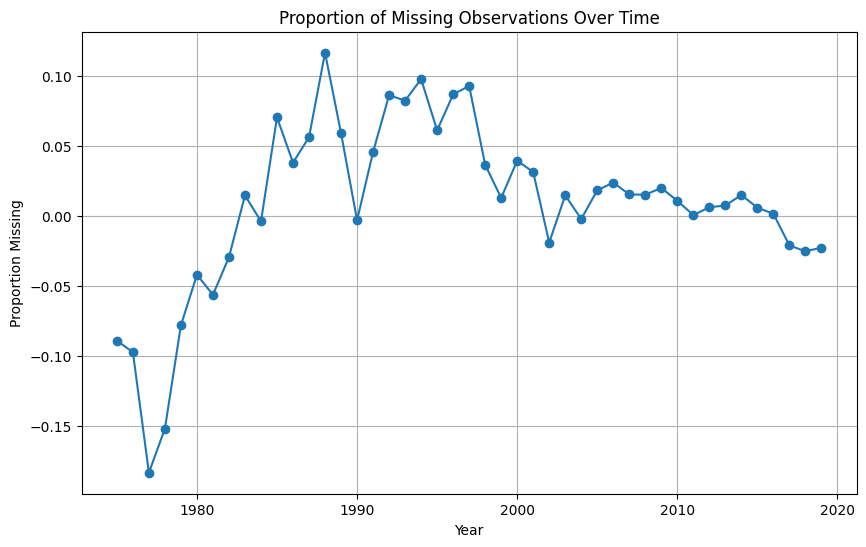

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(comparison_table['Year'], comparison_table['Proportion missing'], marker='o')
plt.title('Proportion of Missing Observations Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion Missing')
plt.grid()
plt.show()

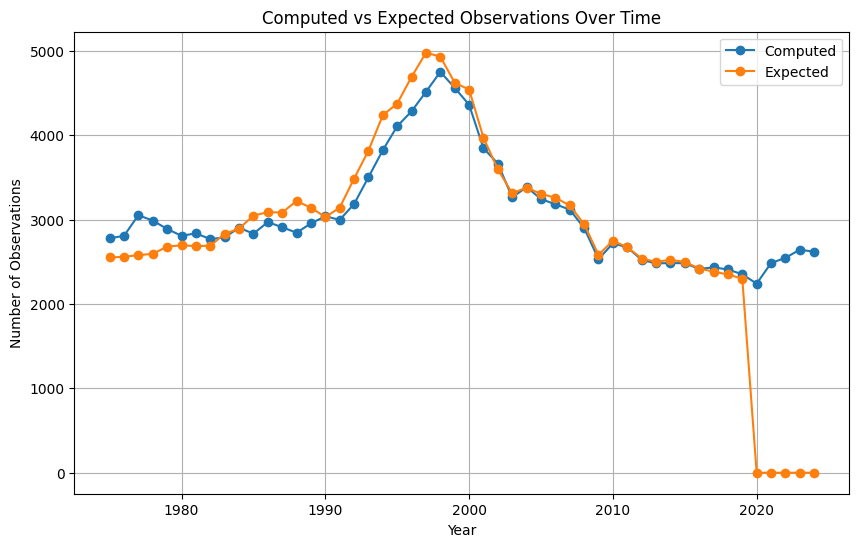

In [18]:
#YoY Expected vs Computed
plt.figure(figsize=(10, 6))
plt.plot(comparison_table['Year'], comparison_table['Calculated # of Firms'], marker='o', label='Computed')
plt.plot(comparison_table['Year'], comparison_table['Expected # of Observations'], marker='o', label='Expected')
plt.title('Computed vs Expected Observations Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.legend()
plt.grid()
plt.show()

In [19]:
total_firms = testing_filtered_data['gvkey'].nunique()
print(f"\nTotal number of unique firms across all years: {total_firms}")


Total number of unique firms across all years: 14941


In [21]:
# Check for missing variable / variable coverage
missing_data = testing_filtered_data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data = missing_data.sort_values
missing_data

<bound method Series.sort_values of xidoc             506
seq                93
pstkl              33
pstkrv             56
be               5762
permco            130
date_x            130
shrcd             130
exchcd            130
ret               130
retx              247
shrout            130
prc               130
dlret             130
dlstdt         152972
retadj            130
me                130
beme             5886
AGt                 1
BTMt             5886
EXRET12Mt+1    105468
SIZEt             130
BMt              5886
MOMt            91960
INVt                1
dtype: int64>

### Saving the data

In [23]:
import os
output_directory = "data"
os.makedirs(output_directory, exist_ok=True)
output_filename = "full_fundamental_dataset.csv"
output_path = os.path.join(output_directory, output_filename)
if os.path.exists(output_path):
    os.remove(output_path)
filtered_data_final.to_csv(output_path, index=False)

parquet_filename = "full_fundamental_dataset.parquet"
parquet_path = os.path.join(output_directory, parquet_filename)
if os.path.exists(parquet_path):
    os.remove(parquet_path)
filtered_data_final.to_parquet(parquet_path)